### Primer 3 - ASCII reader

* Sliku **SOFT_priprema_train.jpg** koristiti za obučavanje veštačke neuronske mreže
* Nakon obučavanja, na slici **SOFT_priprema_test.jpg** pročitati tekst.
Tekst je dat u ASCII formatu gde je svako slovo predstavljeno kao 3 cifre. "032" predstavlja razmak između reči.
**DODATAK** ASCII kod za razmak može biti zamenjen sa duplim razmakom, tako da bi razmak između cifara bio jedan razmak,
a razmak između reči dupli razmak.

In [1]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# k-means
#from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def remove_noise(binary_image):
    ret_val = dilate(dilate(erode(invert(binary_image))))
    return ret_val


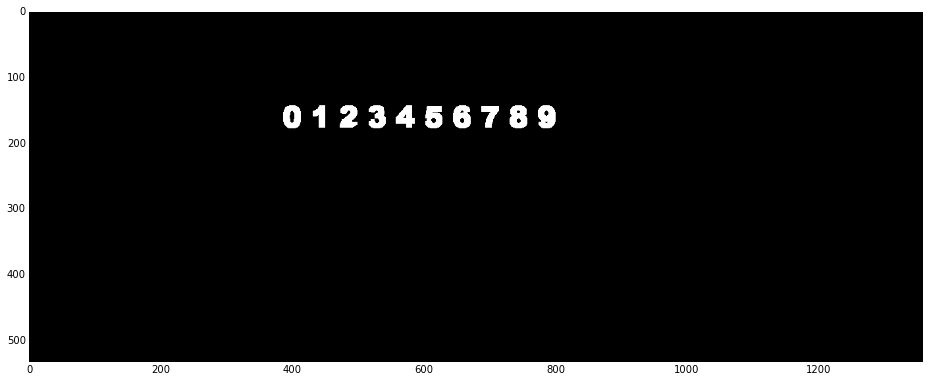

In [17]:
#otklanjanje suma
#img_train = load_image('SOFT_priprema_train.jpg')
#img_train_bin = image_bin(image_gray(img_train))
#img_train_bin = dilate(erode(invert(img_train_bin)))
#display_image(img_train_bin)
img=load_image('SOFT_priprema_train.jpg')
img_bin=image_bin(image_gray(img))
img_bin=remove_noise(img_bin)
#img_bin=dilate(erode(invert(img_bin)))
#img_bin=invert(img_bin)
#img_bin=dilate(erode(img_bin))
display_image(img_bin)

In [14]:
def select_roi(image_orig, image_bin):
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,w,h = cv2.boundingRect(contour)
            
        cv2.rectangle(image_orig,(xt,yt),(xt+w,yt+h),(255,0,0),2)
        region_points = []
        for i in range (xt,xt+w):
            for j in range(yt,yt+h):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
        region = np.ndarray((len(region_points), 2), dtype=np.int16)
        for i, point in enumerate(region_points):
            x = point[0]
            y = point[1]
            region[i] = [x,y]
        contours.append(region)
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])
        
        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
            region[y-min_y,x-min_x] = 255

        
        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    return image_orig, sorted_regions[:, 0]

10


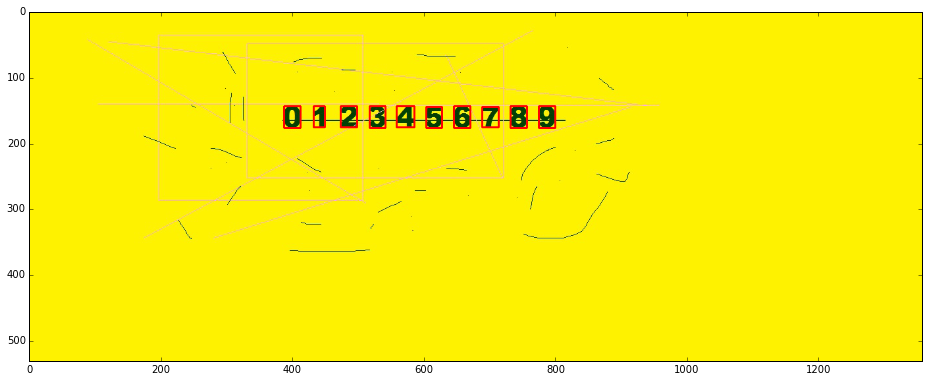

In [15]:
img, selected_regions = select_roi(img_train, img_train_bin)
print len(selected_regions)
display_image(img)

In [16]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=28 * 28, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
    #ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    #ann.add(Activation("sigmoid"))
    #ann.add(Dense(input_dim=128, output_dim=10,init="glorot_uniform"))
    #ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

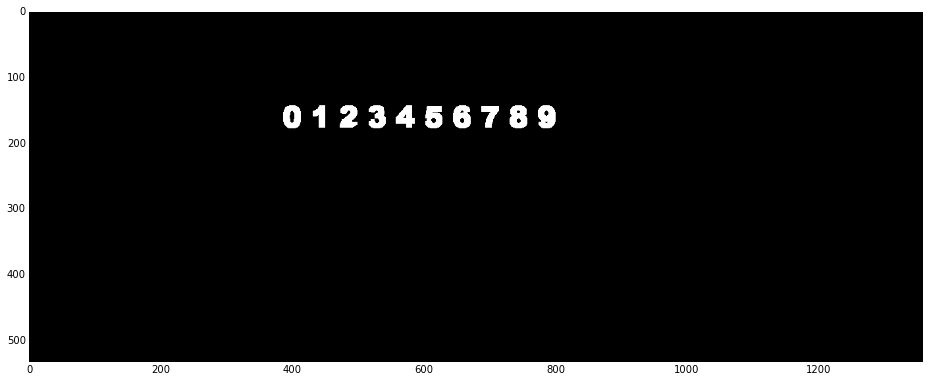

In [18]:
img_train = load_image('SOFT_priprema_train.jpg')
img_train_bin = image_bin(image_gray(img_train))
img_train_bin = remove_noise(image_bin(image_gray(img_train)))
sel_img_train, shapes = select_roi(img_train.copy(), img_train_bin)
display_image(img_train_bin)
inputs = prepare_for_ann(shapes)
alphabet = [0,1,2,3,4,5,6,7,8,9]
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

In [19]:
def display_result(outputs, alphabet):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    ciphers = []
    for idx, output in enumerate(outputs):
        elem = alphabet[winner(output)]
        ciphers.append(elem)
    codes = []
    for i in range(0,len(ciphers),3):
        code = ciphers[i] * 100
        code += ciphers[i+1] * 10
        code += ciphers[i+2]
        codes.append(code)
    result = ""
    for code in codes:
        result += chr(code)
        
    return result

In [12]:
#sel_img_train, shapes = select_roi(img_train.copy(), img_train_bin)
#inputs = prepare_for_ann(shapes)
#results = ann.predict(np.array(inputs, np.float32))
#print display_result(results, alphabet)

39
39
SOFT priprema


39

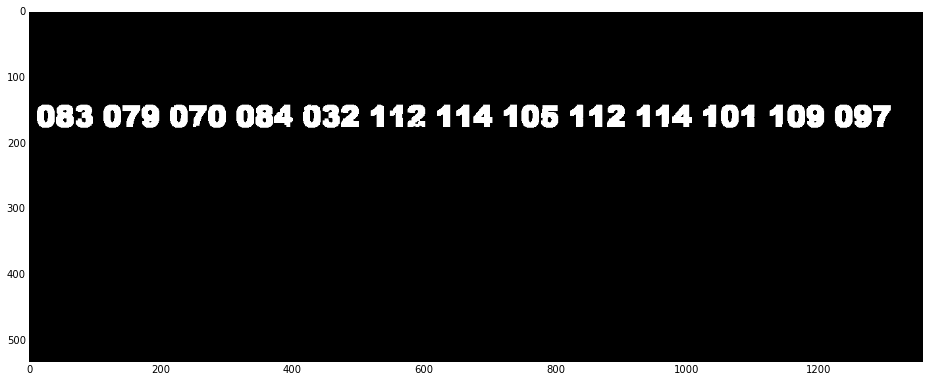

In [20]:
img_test = load_image('SOFT_priprema_test.jpg')
img_test_bin = remove_noise(image_bin(image_gray(img_test)))
display_image(img_test_bin)
sel_img_test, shapes = select_roi(img_test.copy(), img_test_bin)
#display_image(sel_img_test)
print len(shapes)
inputs = prepare_for_ann(shapes)
results = ann.predict(np.array(inputs, np.float32))
print len(results)
print display_result(results, alphabet)
3 * 13